# Figure 3 - Correlation wavefield contribution of a repeating impulsive isolated source

This notebook reproduces Figure 3 of Schippkus et al. 2023 ("Repeating direct waves in the coda of ambient seismic noise cross correlations"). It computes and plots the three factors in the second term of eq. 2 in Schippkus et al. 2023, and its contribution to the correlation wavefield. The three factors are: Auto-correlation of the wavelet, auto-correlation of the excitation pattern, cross-correlation of the Green's functions (isolated source > master station and isolated source > receiver station). The contribution to the correlation wavefield of such a such is the convolution of these three.

In [1]:
import numpy as np
from scipy.signal import ricker, fftconvolve
from obspy import read_inventory
from obspy.geodetics import gps2dist_azimuth
from obspy.signal.util import util_geo_km

# Define time
freq = 10
timelen = 1200
times = np.arange(0, timelen + 1 / freq, 1 / freq)

c = "#3f90da"

# Define geometry
master_station = np.array([-75, -200])
inv = read_inventory("../meta/graefenberg.stationxml")
array_stations_latlon = np.array([(sta.longitude, sta.latitude) for sta in inv[0]])

isolated_source = np.array([-200, 150])

array_stations = []
for sta in array_stations_latlon:
    array_stations.append(
        util_geo_km(
            np.mean(array_stations_latlon[:, 0]),
            np.mean(array_stations_latlon[:, 1]),
            sta[0],
            sta[1],
        )
    )
array_stations = np.array(array_stations)
station = array_stations[0]

dist_master = np.linalg.norm(master_station - isolated_source)
dist_station = np.linalg.norm(station - isolated_source)

# Define medium
# acoustic, isotropic, homogeneous half-space
vel = 3

# Define isolated source wavelet & excitation pattern
wavelet = ricker(len(times), 1.5 * freq)

n_repeat = 5
interval = 20
excitation_pattern = np.zeros(len(times))
excitation_pattern[
    int(interval * freq) : (n_repeat + 1) * int(interval * freq) : int(interval * freq)
] = 1

# Green's functions = Dirac delta functions
gf_master = np.zeros(len(times))
gf_master[int(freq * dist_master / vel)] = 1
gf_station = np.zeros(len(times))
gf_station[int(freq * dist_station / vel)] = 1

# Correlations
wavelet_autocorr = fftconvolve(wavelet, wavelet[::-1], mode="same")
excitation_pattern_autocorr = fftconvolve(
    excitation_pattern, excitation_pattern[::-1], mode="same"
)
gf_corr = fftconvolve(gf_station, gf_master[::-1], mode="same")

# Isolated noise source contribution to the correlation wavefield
# second term of eq. 2, Schippkus et al. 2023
isolated_source_contribution = fftconvolve(
    fftconvolve(wavelet_autocorr, excitation_pattern_autocorr, mode="same"),
    gf_corr,
    mode="same",
)

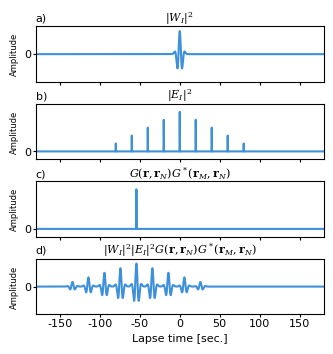

In [2]:
import pylab as plt
from matplotlib.gridspec import GridSpec

lapsetimes = times - times[-1] / 2

_cm = 1 / 2.54
fig = plt.figure(figsize=(8.6 * _cm, 8.6 * _cm))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)

plt.rc("font", size=8)
plt.rc("axes", titlesize=8)
plt.rc("axes", labelsize=8)
plt.rc("xtick", labelsize=8)
plt.rc("ytick", labelsize=8)
plt.rc("legend", fontsize=8)
plt.rcParams["mathtext.fontset"] = "dejavuserif"


gs = GridSpec(4, 1, hspace=0.4, wspace=0, figure=fig)
axs = [fig.add_subplot(gs[_, 0]) for _ in range(4)]
# make consistent and pretty
for ax in axs:
    ax.xaxis.set_tick_params(length=2, pad=1)
    ax.yaxis.set_tick_params(length=2, pad=1)
    ax.set_yticks([0])
    ax.set_xlim(-180, 180)
    ax.set_xticks(np.arange(-150, 150 + 50, 50))
    ax.set_xticklabels([])
    ax.set_ylabel("Amplitude", fontsize=6)

ax = axs[0]
ax.plot(lapsetimes, wavelet_autocorr, c=c)
ax.set_title(f"a)", loc="left", pad=0)
ax.set_title(f"$|W_I|^2$", loc="center", pad=0)
ax.set_ylim(
    -1.2 * np.max(np.abs(wavelet_autocorr)), 1.2 * np.max(np.abs(wavelet_autocorr))
)

ax = axs[1]
ax.set_title(f"b)", loc="left", pad=0)
ax.set_title(f"$|E_I|^2$", loc="center", pad=0)
ax.plot(lapsetimes, excitation_pattern_autocorr, c=c)
ax.set_ylim(
    -0.2 * np.max(np.abs(excitation_pattern_autocorr)),
    1.2 * np.max(np.abs(excitation_pattern_autocorr)),
)

ax = axs[2]
ax.plot(lapsetimes, gf_corr, c=c)
ax.set_title(f"c)", loc="left", pad=0)
ax.set_title(
    r"$G(\mathbf{r}, \mathbf{r}_N) G^*(\mathbf{r}_M,\mathbf{r}_N)$", loc="center", pad=0
)
ax.set_ylim(-0.2 * np.max(np.abs(gf_corr)), 1.2 * np.max(np.abs(gf_corr)))

ax = axs[3]
ax.plot(lapsetimes, isolated_source_contribution, c=c)
ax.set_title(f"d)", loc="left", pad=0)
ax.set_title(
    r"$|W_I|^2 |E_I|^2 G(\mathbf{r}, \mathbf{r}_N) G^*(\mathbf{r}_M,\mathbf{r}_N)$",
    loc="center",
    pad=0,
)
ax.set_ylim(
    -1.2 * np.max(np.abs(isolated_source_contribution)),
    1.2 * np.max(np.abs(isolated_source_contribution)),
)

ax.set_xlabel("Lapse time [sec.]", fontsize=8)
ax.set_xticklabels(np.arange(-150, 150 + 50, 50))

plt.rcParams.update(
    {
        "figure.facecolor": (1.0, 0.0, 0.0, 0.3),  # red   with alpha = 30%
        "axes.facecolor": (0.0, 1.0, 0.0, 0.5),  # green with alpha = 50%
        "savefig.facecolor": (0.0, 0.0, 1.0, 0.0),  # blue  with alpha = 20%
    }
)

fig.savefig("../figures/Fig3_repeating_impulsive_source.pdf", dpi=300)
